# INFO 2950 Final Project - Phase II
##### Janice Shen (js3678), Khai Xin Kuan (kk996), Sandy Lin (sl2534), David Park (yp358)

## Research Questions
Something we found in common between the four of us is our love for music and aspiration in finance. We wondered, can something as personal as individual music preference be somehow related to the greater US economy. This conversation sparked us to research into previous work about music sentiments and the us economy, which seems to give us very promising correlation (such as music sentiment with weekly equity: https://www.sciencedirect.com/science/article/pii/S0304405X21003718#:~:text=We%20find%20that%20music%20sentiment,when%20trading%20restrictions%20limit%20arbitrage).

However, excited as we are, we ask a range of questions, from daring to more pessimistic:

1. Can we predict the valence (a spectrum indicating negative or positive emotions, with 0 indicating most negative and 1 indicating most positive) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?
2. Through this journey, we also wondered how danceability correlated with valence, and subsequently, can we predict the danceability (with 0.0 being the least danceable and 1.0 being the most danceable) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?

Originally, we went and included all songs in our analysis and found the correlation to be extremely weak. We wondered if this was because the data included a large quantity of songs but people didn't listen to some of them, making them irrelevant. Therefore, we revised our data and filter out unpopular songs with a metric of popularity (a scale out of 100, 100 being the most popular), creating a bottleneck of 70 for our top 10000 song data. 

Even then, we saw a weak correlation and wondered if there even is a relation betwen broad music/entertainment with the economy. Does the way people consumer entertainment effect the economy at all? Thus, coming to our final research question:

3. Lastly, taking a huge step back, is there any relationship between the music industry and the economy? More specifically, we ask is there any relation between the GDP and the music/entertainment growth?

In [1]:
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression

## Data Descriptions

1. *First source for different elements of music sentiments (specifically testing danceability and valence)*
This file, named data.csv, was a dataset we found on calebelgut’s github that was said to be scraped directly from Spotify about songs (rows) released from 1921-2020 and different music sentiment element (columns). This data set was original produced to predict popularity from music elements and thus the popularity metric is calculated from today's popularity of a song which could be an issue comparing historic economic data (since huge hits in the 90s for example, could be not so popular today but we are comparing that song in the context of 90s economic data in our project). 
Source:https://github.com/calebelgut/spotify-lstm/tree/main/Data
 
2. *Second source for different elements of music sentiments (specifically testing danceability and valence)*
This file, named top10000song.csv, was a dataset we found on kraggle by Sean Miller who scraped the data from Billboard and ARIA (Australian Recording Industry Association) from the 1950-now, detailing 10,000 most popular Spotify songs (rows) and there music sentiment elements (columns such as Popularity, Energy, and Valence). This again was meant for music fanatics interested in the popularity of musics, but for our project, we liked how the popularity metric was measured from a historitical point of view which we compare with historical economic data (such as unemployment rate). 
Source:https://www.kaggle.com/datasets/joebeachcapital/top-10000-spotify-songs-1960-now    

3. *Source for different economic indicators (specifically testing interest rate, unemployment rate, GDP)*
This file, named Index.csv, is a dataset from kraggle by Abigail Larion, created from the Federal Reserve. This dataset contains data on economic variables (columns) such the monthly federal funds rate, real GDP, and unemployment rate from Jul 1954 - Mar 2017 (each row is a month). 
Source:https://www.kaggle.com/datasets/federalreserve/interest-rates
 
4. *Source From Federal Reserve Bank of St. Louis about monthly unemployment rate data from Jan 1948- Sep 2024 (each row is a month)*
Source:https://fred.stlouisfed.org/series/UNRATE

5. *Source From Federal Reserve Bank of St. Louis about quarterly GDP from Jan 1997-2019 (each row is a quarter)*
Source: https://fred.stlouisfed.org/series/GDP

6. *Source From Federal Reserve Bank of St. Louis about yearly Music/entertainment industry GDP from 1997-2019 (each row is a month)*
Source:https://fred.stlouisfed.org/series/USPRFRMSPRTMSMNGSP

In [2]:
#load all datasets
musicdata = pd.read_csv("data.csv")
econdata = pd.read_csv("index.csv")
undata= pd.read_csv("un.csv")
songdata=pd.read_csv("top10000song.csv")
us_gdp_data = pd.read_csv("GDP.csv")
us_entertainmentgdp_data = pd.read_csv("USPRFRMSPRTMSMNGSP.csv")

# Data Cleaning

We begin to inspect the first 3 datasets by using .head() and .shape to ensure we have enough data. Then we check if there is any NaN value. We only found it in fed fund rate and we dropped the value. This is justified because we then average out the yearly fed fund rate. And this works because the fed fund rate raw data gives us each month's interest rate but the music sentiment is by-yearly scale. We then create a new dataset that contains the average interest rate of the year that matches the yearly scale of the music sentiments. 

### Data Collection and Cleaning
Summary:
We begin to inspect the first 3 datasets by using .head() and .shape to ensure we have enough data. Then we check if there is any NaN value. If there is, we dropped the value. For the interest rate, since the raw data gives us each month's interest rate, we average the 12 months to a by-yearly scale. We then create a new dataset that contains the average interest rate of the year that matches the yearly scale of the music sentiments. 

After cleaning, we created a new dataframe that contains only data that we are interested in exploring the relationship such as danceability, valence, year, interest rate, and unemployment rate by using Inner Join on year (SQL). 

However, after running our analysis, we realized that there was a weak correlation and wanted another dataset to cross check. Thus, we used the top10000 songdata in the second part of this project after inspecting and analyzing the first 3 data sets with the spotify dataset of music sentiments. 

In [3]:
#understand the all musicdata we have in the dataset and check the shape to see if we have enough data
print(musicdata.head())
print(musicdata.shape)

   acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       104300  0.2200         0  6L63VW0PibdM1HDSBoqnoM             0.000   
3       180760  0.1300         0  6M94FkXd15sOAOQYRnWPN8             0.887   
4       687733  0.2040         0  6N6tiFZ9vLTSOIxkj8qKrd             0.908   

   key  liveness  loudness  mode  \
0   10    0.1510   -12.428     1   
1    8  

In [4]:
# checking to see if we have NaN values
print("Number of music valence: ", len(musicdata['valence']))
print("Nan is present: ",\
      np.isnan(musicdata['valence']).any())

Number of music valence:  169909
Nan is present:  False


In [5]:
# checking to see if we have NaN values
print("Number of music danceability: ", len(musicdata['danceability']))
print("Nan is present: ",\
      np.isnan(musicdata['danceability']).any())

Number of music danceability:  169909
Nan is present:  False


In [6]:
# confirm the scale of popularity
musicdata['popularity'].unique()

array([  0,   1,   2,   3,   7,   6,   5,   4,   8,  14,  13,  11,  10,
        12,   9,  15,  19,  17,  18,  16,  20,  24,  21,  23,  22,  25,
        42,  28,  27,  37,  36,  35,  30,  26,  29,  44,  32,  33,  31,
        41,  46,  34,  45,  40,  38,  39,  54,  48,  58,  52,  47,  43,
        49,  51,  56,  55,  50,  57,  59,  66,  53,  61,  60,  62,  64,
        65,  69,  72,  63,  70,  68,  67,  71,  74,  75,  78,  81,  77,
        73,  80,  76,  79,  82,  83,  85,  84,  91,  92,  87,  86,  89,
        95,  93,  88,  90,  94,  99,  96, 100,  97])

In [7]:
#check the mean, mode and median of songs' popularity
print(musicdata['popularity'].mean())
print(musicdata['popularity'].mode())
print(musicdata['popularity'].median())

31.55660971461194
0    0
Name: popularity, dtype: int64
33.0


In [8]:
# create a new music dataset that only contain songs with popularity more than 70

In [10]:
newmusicdata= duckdb.sql("SELECT danceability, valence, year, popularity FROM musicdata WHERE popularity>=40").df()
newmusicdata

,danceability,valence,year,popularity
0,0.596,0.599,1960,42
1,0.514,0.559,1966,44
2,0.694,0.961,1967,41
3,0.506,0.646,1967,46
4,0.438,0.460,1969,45
...,...,...,...,...
67941,0.875,0.306,2020,75
67942,0.719,0.270,2020,64
67943,0.514,0.153,2020,70
67944,0.646,0.472,2020,70


In [11]:
# count the number of songs available for each year
songsinyear = duckdb.sql("SELECT COUNT(Year) AS Count, Year FROM \
            newmusicdata GROUP BY Year ORDER BY Count DESC").df()
songsinyear.head(64)

,Count,year
0,2000,2010
1,2000,2011
2,2000,2012
3,2000,2013
4,2000,2014
...,...,...
59,148,1962
60,123,1958
61,105,1960
62,100,1957


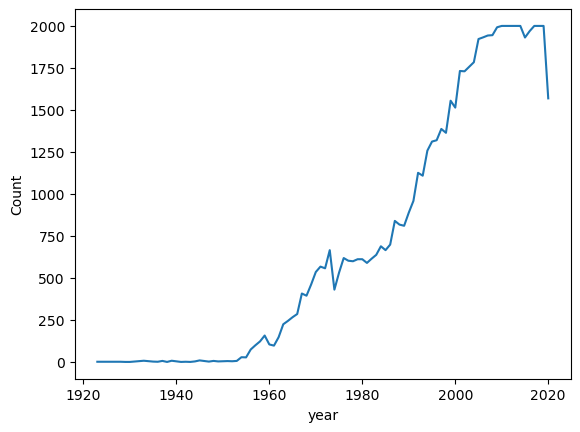

In [12]:
songsinyear_graph = sns.lineplot(songsinyear, x="year", y="Count")

As we have uneven number of songs for each year, we need to think it will skew our analysis later. Hence we decide to only include songs from 2000 to 2015.

In [ ]:
# look at the mean, median of danceability and valence for each year 
newmusicdata = duckdb.sql("SELECT danceability, valence, year FROM newmusicdata WHERE year>=2000 AND year<=2017").df()
newmusicdata


In [ ]:
#understand the all econdata we have in the dataset and check the shape to see if we have enough data
print(econdata.head())
print(econdata.shape)

In [ ]:
# checking to see if we have NaN values
print("Number of rows in fed fund rate: ", len(econdata['Effective Federal Funds Rate']))
print("Nan is present: ",\
      np.isnan(econdata['Effective Federal Funds Rate']).any())

In [ ]:
#Nan vaue is found, drop it 
econdata.dropna(subset=['Effective Federal Funds Rate'], inplace=True)
print(np.isnan(econdata['Effective Federal Funds Rate']).any())
#check the shape to see if we have enough data
print(econdata.shape)


In [ ]:
#rename the Effective Federal Funds Rate col, easier without space for writing SQL later
print(econdata.columns)
econdata.rename(columns={"Effective Federal Funds Rate": "fedfundrate"}, inplace=True)
print(econdata.columns)

In [ ]:
# modify econdata to find avg feadfundrate for each year
econdata = duckdb.sql("SELECT Year, AVG(fedfundrate) AS fedfundrate FROM econdata GROUP BY Year").df()
econdata

In [ ]:
#understand the all interestdata we have in the dataset and check the shape to see if we have enough data
print(undata.head())
print(undata.shape)

In [ ]:
# checking to see if we have NaN values
print("Number of rows in UNRate: ", len(undata['UNRATE']))
print("Nan is present: ",\
      np.isnan(undata['UNRATE']).any())

In [ ]:
# in order to merge the data, we need to convert the date format into datetime

#check date type
print(undata["DATE"].dtype)
# convert to datetime format
undata['DATE']= pd.to_datetime(undata['DATE'], format='%Y-%m-%d', errors='coerce')
undata

Data manipulation: we average the interest rate and grouped by year to be the same scale as the spotify dataset. 

In [ ]:
# modify undata to find avg unrate for each year
newundata = duckdb.sql("SELECT year(DATE) AS Year, AVG(UNRATE) AS UnemploymentRate FROM undata GROUP BY year(DATE)").df()
newundata

In [ ]:
#understand the all usgdp data we have in the dataset and check the shape to see if we have enough data
print(us_gdp_data.head())
us_gdp_data.shape

In [ ]:
# rename entertainmentgdp col for easier reference
us_gdp_data = us_gdp_data.rename(columns={"GDP": "US_GDP"})
us_gdp_data

In [ ]:
#understand the all us_entertainmentgdp data we have in the dataset and check the shape to see if we have enough data
print(us_entertainmentgdp_data.head())
us_entertainmentgdp_data.shape

In [ ]:
# rename entertainmentgdp col for easier reference
us_entertainmentgdp_data = us_entertainmentgdp_data.rename(columns={"USPRFRMSPRTMSMNGSP": "Entertainment_GDP"})
us_entertainmentgdp_data

In [ ]:
# merge the 2 datasets tgt on date. (only interested in jan 1st since entertainmentgdp dataset only has jan 1st data
gdp_entgdp_df = pd.merge(us_gdp_data, us_entertainmentgdp_data, how="inner", on="DATE")
gdp_entgdp_df 

In [ ]:
# in order to merge with other datasets, we need to convert the date format into datetime

#check date type
print(gdp_entgdp_df["DATE"].dtype)
# convert to datetime format
gdp_entgdp_df['DATE']= pd.to_datetime(gdp_entgdp_df['DATE'], format='%Y-%m-%d', errors='coerce')
gdp_entgdp_df

In [ ]:
gdp_entgdp_df = duckdb.sql("SELECT year(DATE) AS Year, US_GDP, Entertainment_GDP FROM gdp_entgdp_df").df()
gdp_entgdp_df.columns

In [ ]:
# use sql to get a data frame with danceabilty, valence, interest rate and unemployment
cleandata= duckdb.sql("SELECT danceability,valence, \
            newmusicdata.year, fedfundrate FROM\
            newmusicdata INNER JOIN econdata ON \
            newmusicdata.year = econdata.Year").df()
cleandata= duckdb.sql("SELECT danceability,valence, \
            cleandata.year, \
            fedfundrate, UnemploymentRate FROM cleandata INNER JOIN newundata\
            ON cleandata.year = newundata.Year").df()
cleandata= duckdb.sql("SELECT danceability,valence, \
        cleandata.year, \
        fedfundrate, UnemploymentRate, US_GDP, Entertainment_GDP FROM cleandata INNER JOIN gdp_entgdp_df\
        ON cleandata.year = gdp_entgdp_df.Year").df()
cleandata

### Data visualization and analysis


In [ ]:
# inspect the correlation
cleandata.corr()

Danceability and valence has a highest correlation as what we expected. However, danceability has a weak +ve correlation with Unemployment rate (0.04) and a weak -ve correlation (-0.02) with fedfundrate. In addition, valence has an even lower +ve correlation with Unemployment rate (0.007)and Interest Rate (0.1). 


Visualize the highest correlation in the table between US and US Entertainment GDP.

In [ ]:
sns.scatterplot(data=cleandata, x="US_GDP", y="Entertainment_GDP")

In [ ]:
# visualize time series of valence and danceability across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax1, color='blue', label='danceability')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

From the graph, we can see that the overall trend between danceability and valence is mostly similar, except for the period from 2010 onwards, where danceability increases while valence decreases. Note that both danceability and valence are the average of that year as we have multiple songs in a year from the dataset. 

In [ ]:
# visualize time series of valence and fedfundrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='fedfundrate', data=cleandata, ax=ax1, color='blue', label='fedfundrate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

In [ ]:
# visualize time series of danceability and fedfundrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='fedfundrate', data=cleandata, ax=ax1, color='blue', label='fedfundrate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax2, color='red', label='danceability')

In [ ]:
# visualize time series of valence and unemploymentrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='UnemploymentRate', data=cleandata, ax=ax1, color='blue', label='UnemploymentRate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

In [ ]:
# visualize time series of danceability and unemploymentrate across the years
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='UnemploymentRate', data=cleandata, ax=ax1, color='blue', label='UnemploymentRate')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax2, color='red', label='danceability')

Inspect why dancebility and valence has such weak correlation with fedfundrate and unemploymentrate by plotting scatter plots. 
We found out that regardless of the fed fund rate and unemployment rate, we have songs with a full spectrum of danceability and valence. This might justify why there is a week correlation. 

NOTE: we reduce the transparency of the dot to make sure we can determine overlapping to get more accurate perceptions of the fange of songs' danceability and valence. 

In [ ]:
dance_fedfund_graph= sns.scatterplot(cleandata, x="fedfundrate", y="danceability", alpha=0.6)


In [ ]:
valence_fedfund_graph= sns.scatterplot(cleandata, x="fedfundrate", y="valence", alpha=0.6)

In [ ]:
dance_un_graph= sns.scatterplot(cleandata, x="UnemploymentRate", y="danceability", alpha=0.6)

In [ ]:
valence_un_graph= sns.scatterplot(cleandata, x="UnemploymentRate", y="valence", alpha=0.6)

END Khai 1.33pm (cells below are not needed, all cells are merged)

### Data Cleaning
While looking through the different factors of calebelgut's dataset, we realized that a potential problem that caused the low correlation may be due to the fact that we did not account for each song's popularity, thus not accurately representing the music sentiment of the general population. Therefore we did further data cleaning and only considered songs above a certain popularity.**

The Popularity scale was from 0 to 100 and after looking at summary stats, we decided to filter to only songs with a rating greater or equal to 70.

In [ ]:
# confirm the scale of popularity
musicdata['popularity'].unique()

In [ ]:
#check the mean, mode and median of songs' popularity
print(musicdata['popularity'].mean())
print(musicdata['popularity'].mode())
print(musicdata['popularity'].median())

In [ ]:
#create a dataframe just as before but with popularity>=70

# checking to see if we have NaN values
print("Number of music popularity: ", len(musicdata['popularity']))
print("Nan is present: ",\
      np.isnan(musicdata['popularity']).any())

In [ ]:
# use sql to get a data frame with danceabilty, valence, popularity, interest rate and unemployment rate
popdata= duckdb.sql("SELECT danceability, valence, popularity, musicdata.year, fedfundrate FROM\
            musicdata INNER JOIN econdata ON musicdata.year = econdata.year WHERE popularity >=70").df()
popdata= duckdb.sql("SELECT danceability, valence, popularity, popdata.year, \
        fedfundrate, UnemploymentRate FROM popdata INNER JOIN newundata\
            ON popdata.year = newundata.Year").df()
popdata

### Data Analysis

In [ ]:
popdata.corr()

Danceability and valence has a highest correlation (from 0.55 to 0.41) as what we expected but lower than what we had before filtering out songs with popularity less than 70. However, danceability has a weaker +ve correlation with Unemployment rate (from 0.04 to 0.03) and a greater -ve correlation (-0.02 to -0.08) with fedfundrate. In addition, valence has a significant higher +ve correlation with Unemployment rate (from 0.007 to 0.06)and fedfundrate (0.1 to 0.25). 

In [ ]:
dance_fedfund_graph= sns.scatterplot(popdata, x="fedfundrate", y="danceability", alpha=0.1)

In [ ]:
valence_fedfund_graph= sns.scatterplot(popdata, x="fedfundrate", y="valence", alpha=0.1)

In [ ]:
dance_un_graph= sns.scatterplot(popdata, x="UnemploymentRate", y="danceability", alpha=0.1)

In [ ]:
valence_un_graph= sns.scatterplot(popdata, x="UnemploymentRate", y="valence", alpha=0.1)

Since we notice some the number of very popular songs in each year is different, we think it could affect the corr. As such, we decide to look at the mean, median  and mode of danceability and valence for each year and compare it to the fedfundrate and unemploymentrate

In [ ]:
# look at the mean, median  and mode of danceability and valence for each year correspond to the fedfundrate and unemploymentrate
analysis = duckdb.sql("SELECT AVG(danceability), MEDIAN(danceability), \
        MODE(danceability), AVG(valence), MEDIAN(valence), \
        MODE(valence), year, fedfundrate, UnemploymentRate FROM popdata GROUP BY year, fedfundrate, UnemploymentRate").df()
analysis

In [ ]:
analysis.corr()

### Sanity check

We decide to use another dataset to check if we can yield better corr. This dataset contains top 10000 songs from 1960 to 2023 and has valence a column.

### Data Cleaning

In [ ]:
#rename the Album Release Date col, easier without space for writing SQL later
print(songdata.head())
songdata.rename(columns={"Album Release Date": "Album_Release_Date"}, inplace=True)
songdata

In [ ]:
songdata['Album_Release_Date'] = pd.to_datetime(songdata['Album_Release_Date'], format='%Y-%m-%d', errors='coerce')

In [ ]:
songdata = duckdb.sql("SELECT *, year(Album_Release_Date) AS year FROM songdata").df()
songdata

In [ ]:
# no need to get popularity here in this dataset, b/c 
# this new data includes top 10000 songs
newcleandata= duckdb.sql("SELECT songdata.Year,\
        valence, UnemploymentRate FROM songdata INNER JOIN \
        newundata ON songdata.year = newundata.year").df()
newcleandata= duckdb.sql("SELECT newcleandata.year,\
        valence, UnemploymentRate, fedfundrate FROM newcleandata INNER JOIN \
        econdata ON newcleandata.year = econdata.year").df()

newcleandata

In [ ]:
# checking to see if we have NaN values
print("Number of rows in valence: ", len(newcleandata['Valence']))
print("Nan is present: ",\
      np.isnan(newcleandata['Valence']).any())

In [ ]:
#examine the data corr 
newcleandata.corr()

The correlation of valence and unemployment rate is different to the first data set, we have -0.01 and we have 0.06 in the previous dataset. 
The correlation between valence and fedfunddate is 0.15 and previously 0.25 (almost similar).

# Attempt 3

***Turning Point***

https://fred.stlouisfed.org/series/GDP
https://fred.stlouisfed.org/series/USPRFRMSPRTMSMNGSP


In [ ]:

us_gdp_data = pd.read_csv("GDP.csv")
us_entertainmentgdp_data = pd.read_csv("USPRFRMSPRTMSMNGSP.csv")

us_gdp_data.head()
print(us_entertainmentgdp_data.dtypes)
print(us_entertainmentgdp_data.columns)

In [ ]:
us_entertainmentgdp_data = us_entertainmentgdp_data.rename(columns={"USPRFRMSPRTMSMNGSP": "Entertainment_GDP"})
us_entertainmentgdp_data.tail()

In [ ]:
gdp_ent_df = pd.merge(gdp_df, entertainment_df, how="inner", on="DATE")
gdp_ent_df.tail()

In [ ]:
# simplifying the column name USPRFRMSPRTMSMNGSP to ENT
gdp_ent_df = gdp_ent_df.rename(columns={"USPRFRMSPRTMSMNGSP": "ENT"})

sns.scatterplot(data=gdp_ent_df, x="GDP", y="ENT")

In [ ]:
gdp_ent_df[["GDP", "ENT"]].corr()

# Data Limitations
The first dataset from spotify  defines the popularity of a song from the current viewership  while the second data set (top 10000 songs) defines popularity from a historical perspective (how popular was a top hit during its age). In our context, the second dataset would be better suited since we are comparing the unemployment rate or interest rate of that period to the popularity of songs of that period. Thus, comparing historical economic data with current popularity could obscure our research. 

Secondly, we soon realized that the simple variables we picked actually turned out to be not so simple. The danceability and valence curve, the interest rate and unemployment rate curve are all complex measures that oscillate and spike in unpredictable trends. Thus, we tried to fit linear relationships to the data which was difficult. This may be due to the fact that many factors contribute to music consumption and sentiment, such as, changing music taste/consumption and current event (covid for example) that fundamentally changes how people behave and thus changing music preference and taste. For example, when people are employed, they are happier and consumer happier music (shown in data set 2 where unemployment rate has a negative correlation with valence in music) but in another perspective, when people are unemployment, the need more happy music (shown in data set 1, where unemployment rate has a positive correlation with valence in music). 

Lastly, we believe that due to the complex nature of virtually all the indicators we picked, we want to inspect more variables that would strengthen our model. Variables we have in mind are genres of music, socio-economics factors, other econ factors, music taste/preferences, and so on. 


One limitation is that the first spotify data set defines the popularity of a song from the current viewership perspective, making it not representative of historical data. 

Another limitation is that the unemployment raw data itself is missing some values that we dropped. Although this doesn’t affect greatly since we average the months of that year’s unemployment data, this could cause the average to be higher or lower due to the dropped month’s historical trend (for example, the february month could be usually lower than january data, making the overall yearly employment higher than it actually is). 

The spotify data set and 2nd song data (top10000 songs) set that we have represent the popularity globally. Couldn't find a dataset based on only the US population.

#### Questions
- Our data (see the graphs near the beginning) are very not linear friendly, how can we transform it or make sense of it?
- Given the low correlation and linear regression coefficient, is there a better model for us to train the data?
- How can we transform our model to better fit the data?
- How and do we have to cite resources?